# Notebook to plot the history

In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
class PlotStyler():
    def __init__(self, n, cmap="Set1", change_linestyle=True):
        assert cmap in ["hsv", "Set1", "Accent"]
        self.cmap = cmap
        self.i = -1
        self.n = n
        self.cm = plt.get_cmap(cmap)
        if change_linestyle:
            self.linestyles = [
                "solid", "dotted", "dashed", "dashdot", 
                (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1)), (0, (3, 5, 1, 5, 1, 5))
            ]
        else:
            self.linestyles = ["solid"]

    def get(self):
        self.i += 1
        ls = self.linestyles[self.i % len(self.linestyles)]
        if self.cmap in ["hsv", "Accent"]:
            c = self.cm(self.i/self.n)
        else:
            c = self.cm(self.i)
        return c, ls
    

In [3]:
def plot(d, xlim=None, ylim=None, title=None, plot_limbs=False, replace_reward_by_success_rate=False):
    generations = d["generations"]
    best_rewards = d["best_rewards"]
    mean_rewards = d["mean_rewards"]
    min_rewards = d["min_rewards"]
    species_mean_rewards = d["species_mean_rewards"]
    species_eval_rewards = d["species_eval_rewards"]
    num_limbs = d["num_limbs"]
    num_species = len(species_eval_rewards[0])
    if replace_reward_by_success_rate:
        species_eval_rewards = d["success_rates"]
        ylim = (0, 1)

    plt.rcParams["font.size"] = 30
    ps = PlotStyler(16)
    fig=plt.figure(figsize=(16, 10), dpi= 80, facecolor="w", edgecolor="k")
    if title is not None:
        fig.suptitle(title)
    ax1 = fig.add_subplot(111)

    # Decide the color and line style first
    styles = []
    for i in range(num_species):
        styles.append(ps.get())

    if plot_limbs:
        # rigid parts graph
        c, ls = ps.get()
        ax2 = ax1.twinx()
        ax2.plot(generations, num_limbs[:, 0], color=c, linestyle = ls, label="number of rigid parts")

    # reward graph
    for i in range(num_species):
        c, ls = styles[i]
        label = f"reward in worker {i+1}"
        if num_species == 1:
            label = "reward"
        ax1.plot(generations, species_mean_rewards[:, i], color=c, alpha=0.2)
        ax1.plot(generations, species_eval_rewards[:, i], color=c, linestyle = ls, label=label)

    h, l = ax1.get_legend_handles_labels()
    if plot_limbs:
        h2, l2 = ax2.get_legend_handles_labels()
        h += h2
        l += l2
        ax2.set_ylabel("num_limbs")
        
    plt.rcParams["font.size"] = 24
    if "ax2" in locals():
        # To eliminate overlap with ax2 graph
        ax2.legend(h, l, loc="upper left")
    else:
        ax1.legend(h, l, loc="upper left")
    ax1.set_xlabel("generation")
    ax1.set_ylabel("reward")

    if ylim is not None:
        ax1.set_ylim(ylim)
    if xlim is not None:
        ax1.set_xlim(xlim)
        if plot_limbs:
            ax2.set_xlim(xlim)

def extract_data(d):
    generations = np.array([h["generation"] for h in d])
    elapseds = np.array([h["elapsed"] for h in d])
    best_species_eval_rewards = np.array([h["best_reward"] for h in d])
    best_rewards = np.array([h["current_best_reward"] for h in d])
    mean_rewards = np.array([h["current_mean_reward"] for h in d])
    min_rewards = np.array([h["current_min_reward"] for h in d])
    species_mean_rewards = np.array([h["current_mean_rewards"] for h in d])
    species_eval_rewards = np.array([h["current_eval_rewards"] for h in d])
    success_rates = np.mean(np.array([h["success_rate"] for h in d]), axis=2)
    num_limbs = np.array([h["num_limbs"] for h in d])
    return {
        "generations": generations,
        "elapseds": elapseds,
        "best_species_eval_rewards": best_species_eval_rewards,
        "best_rewards": best_rewards,
        "mean_rewards": mean_rewards,
        "min_rewards": min_rewards,
        "species_mean_rewards": species_mean_rewards,
        "species_eval_rewards": species_eval_rewards,
        "success_rates": success_rates,
        "num_limbs": num_limbs
    }

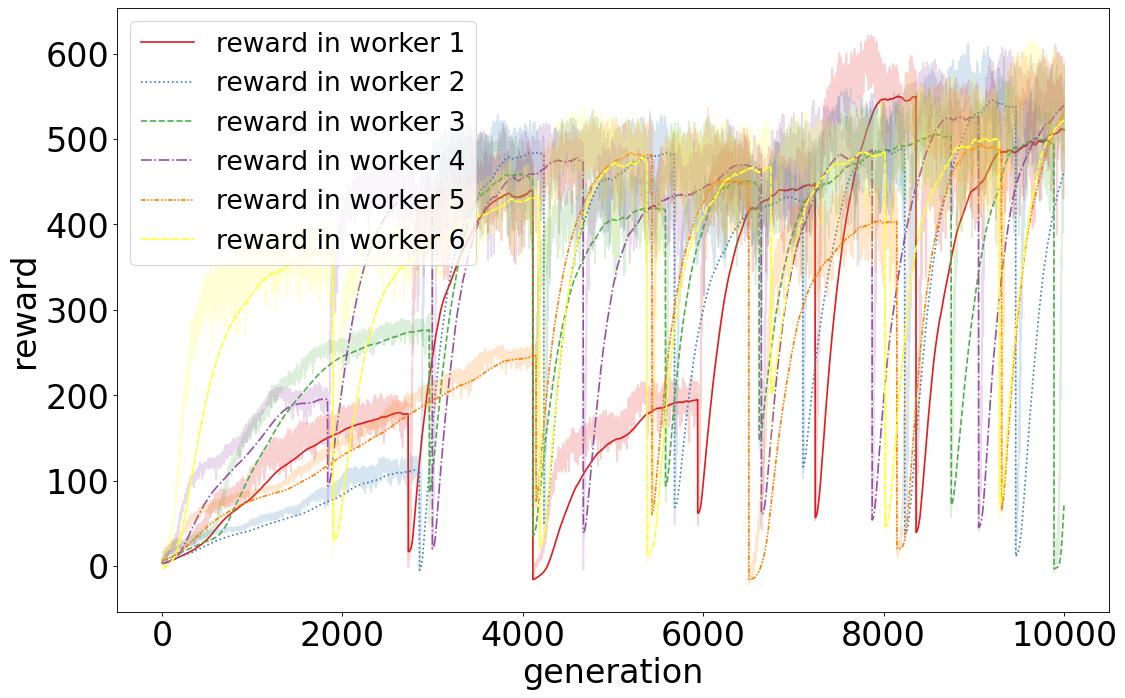

In [4]:
simname = "old/0.8.8_20220203_225723"
# simname = "old/0.8.8_20220205_213427"

# Data collection
filename = os.path.join("log", simname, "history.json")
with open(filename, "r") as f:
    d = extract_data(json.load(f))

plot(d)